# <span style="color:blue">A/B Testing - Facebook</span> 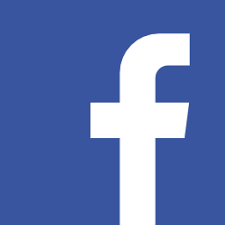



 

**Description of the A/B Testing Analysis:**

Facebook recently introduced a new bidding system called "average bidding"(test group) alongside the existing "maximum bidding"(control group) system. These bidding systems determine which ads get displayed to users based on how much advertisers are willing to pay.

- **Control Group (maximum bidding):** advertisers specify the maximum amount they are willing to pay for each impression. For example, an advertiser might say, I'm willing to pay a maximum of $10 for each impression.
  
- **Test Group (average bidding):** advertisers specify an average amount they are willing to pay for impressions. For instance, they might say, "On average, I'm willing to pay $6 for each impression."

In the dataset, there are the results of these two bidding strategies over the last 40 days to see which one is more effective at getting their ads displayed to the target audience.



The dataset includes the following metrics split in two datasets:
- **Impression:** Number of impressions per ad.
- **Click:** Numbers of clicks per ad.
- **Purchase:** The number of products purchased after the click.
- **Earnings:** Earning after purchase.

**Test Aims:**

The mission is to unearth the most advantageous approach for Facebook. Based on the following burning questions:

- **Maximize Clicks and Purchases:** Which strategy will propel us toward our goal of skyrocketing clicks and driving purchases?
- **Battle of Titans:** Is there a discernible and statistically significant difference between the two bidding options?

The outcome of this AB Test will not just answer our questions but will be the harbinger of a glorious era in our Facebook advertising endeavors. Stay tuned for a transformation that will leave a mark on the digital advertising landscape.


- **Null Hypothesis (H₀):** There is no significant difference in the number of purchases between the control group (maximum bidding) and the test group (average bidding).
- **Alternative Hypothesis (H₁):** Moving to specifying an average amount (average bidding) produce an increase in the average of number of clicks/purchases.

In [148]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.weightstats import ztest as ztest
import matplotlib.pyplot as plt
import seaborn as sns

control_df = pd.read_csv('/kaggle/input/facebook-ab-test-of-bidding-feature/ab_test/control_group.csv')
test_df = pd.read_csv('/kaggle/input/facebook-ab-test-of-bidding-feature/ab_test/test_group.csv')

# New column by Group
control_df['Group'] = 'control_group'
test_df['Group'] = 'test_group'
df = pd.concat([control_df, test_df], ignore_index=True)

df.head()


,Impression,Click,Purchase,Earning,Group
0,82529,6090,665,2311,control_group
1,98050,3383,315,1743,control_group
2,82696,4168,458,1798,control_group
3,109914,4911,487,1696,control_group
4,108458,5988,441,1544,control_group


In [123]:
#Check if there is any missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 Impression    0
Click         0
Purchase      0
Earning       0
Group         0
dtype: int64


##  <span style="color:blue">Facebook Statistics</span>

Let's deep dive in the different statistics that can be useful to observe and perfom during the analysis of the A/B Testing  <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRffPW6bFotdy6auFDV2E9TWp6pn8N-1AE86w&s" align='right' style="width: 100px;"/>

In [124]:
# Interaction information
print(f"{df['Impression'].sum(): ,} total number of impressions")
print(f"{df['Click'].sum(): ,} total number of clicks")
print(f"{df['Purchase'].sum(): ,} total number of products purchased after click")
print(f"{df['Earning'].sum(): ,} total amount earned")

 8,888,955 total number of impressions
 362,727 total number of clicks
 45,318 total number of products purchased after click
 176,940 total amount earned


In [125]:
#number of purchases by group
total_purchase=df.groupby('Group').agg({'Purchase': ['sum', 'mean'],'Click': ['sum', 'mean']})
purchase_sum = total_purchase['Purchase', 'sum'].sum()
#click_sum=df['Click'].sum()
total_purchases_test=test_df['Purchase'].sum()
total_purchases_control=control_df['Purchase'].sum()
total_click_test=test_df['Click'].sum()
total_click_control=control_df['Click'].sum()
# total_purchase['click_by_purchase'] = round((purchase_sum / click_sum) * 100, 2).astype(str) + '%'
total_purchase['percentage'] = round((total_purchase[('Purchase', 'sum')] / purchase_sum) * 100, 2).astype(str) + '%'


total_purchase['click_by_purchase'] = [round((total_purchases_control / total_click_control)*100,2).astype(str) + '%', round((total_purchases_test / total_click_test)*100,2).astype(str) + '%']


# click_sum=df['Click'].sum()
# total_purchase['click_by_purchase'] = round((purchase_sum / click_sum) * 100, 2).astype(str) + '%'

total_purchase



Purchase           Click           percentage click_by_purchase
                   sum    mean     sum      mean                             
Group                                                                        
control_group    22036  550.90  204025  5100.625     48.63%             10.8%
test_group       23282  582.05  158702  3967.550     51.37%            14.67%

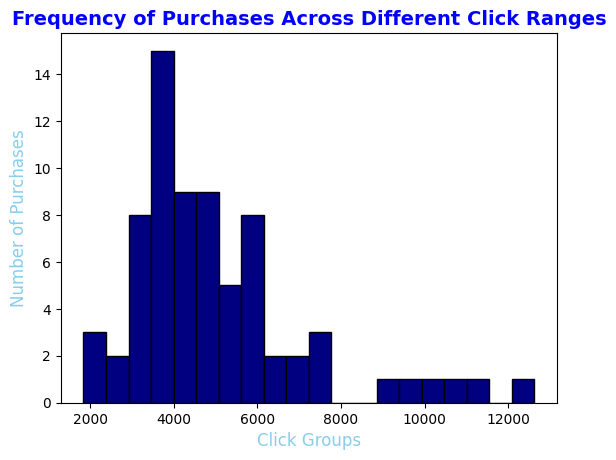

In [126]:
# Distribution purchase
plot_bar = df.groupby('Purchase')['Click'].sum()

plt.hist(plot_bar, bins=20, color='navy', edgecolor='black')

plt.title("Frequency of Purchases Across Different Click Ranges", fontweight="bold", size=14, color='blue')
plt.xlabel("Click Groups", size=12, color='skyblue')
plt.ylabel("Number of Purchases", size=12, color='skyblue')

plt.show()



<span style="color:navy"> The graphic above shows how purchases are distributed across different total click counts, with each bar representing the frequency of purchases within a specific click range.

<span style="color:navy"> So far in our purchase information we can see that only the 12.49% of clicks turned up into purchases, split around 50% between the two groups.


In [127]:
total_earns_bygroup=df.groupby('Group')[['Earning']].sum()
total_earns_bygroup

,Earning
Group,
control_group,76343
test_group,100597


##  <span style="color:blue">A/B Test</span>

In [137]:
# Separate data for each group
maximum_bidding_purchase = df[df['Group'] == 'control_group']['Purchase']
average_bidding_purchase = df[df['Group'] == 'test_group']['Purchase']

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(maximum_bidding_purchase, average_bidding_purchase, alternative='greater', equal_var=False)

# Output the results
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Evaluate the null hypothesis
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis (H₀): The means are significantly different.")
else:
    print("Fail to reject the null hypothesis (H₀): The means are not significantly different.")

T-Statistic: -0.9396
P-Value: 0.8248
Fail to reject the null hypothesis (H₀): The means are not significantly different.


In [138]:
# Calculate sample means, variances, and sizes for each group
mean_maximum_bidding_purchase = maximum_bidding_purchase.mean()
mean_average_bidding_purchase = average_bidding_purchase.mean()
var_maximum_bidding_purchase  = maximum_bidding_purchase.var(ddof=1)
var_average_bidding_purchase = average_bidding_purchase.var(ddof=1)
n_maximum_bidding_purchase  = len(maximum_bidding_purchase)
n_average_bidding_purchase = len(average_bidding_purchase)

# Calculate the difference in means
mean_diff = mean_average_bidding_purchase - mean_maximum_bidding_purchase

# Standard error of the difference in means
se_diff = np.sqrt(var_maximum_bidding_purchase / n_maximum_bidding_purchase + var_average_bidding_purchase / n_average_bidding_purchase)

# Degrees of freedom for Welch's t-test
degrees_freedom = 1

# Critical t-value for 95% confidence interval
t_critical = stats.t.ppf(1 - 0.025, degrees_freedom)

# Confidence interval
ci_lower = mean_diff - t_critical * se_diff
ci_upper = mean_diff + t_critical * se_diff
confidence_interval = (ci_lower, ci_upper)

# Output the results
print(f"Mean Difference: {mean_diff:.4f}")
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean Difference: 31.1500
95% Confidence Interval: (-390.0902, 452.3902)


In [140]:
# Separate data for each group
maximum_bidding_click = df[df['Group'] == 'control_group']['Click']
average_bidding_click = df[df['Group'] == 'test_group']['Click']

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(average_bidding_click, maximum_bidding_click, alternative='greater', equal_var=False)

# Output the results
print(f"T-Statistic: {t_stat:.4f}")
print(f"P-Value: {p_value:.4f}")

# Evaluate the null hypothesis
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis (H₀): The means are significantly different.")
else:
    print("Fail to reject the null hypothesis (H₀): The means are not significantly different.")

T-Statistic: -4.4266
P-Value: 1.0000
Fail to reject the null hypothesis (H₀): The means are not significantly different.


In [141]:
# Calculate sample means, variances, and sizes for each group
mean_maximum_bidding_click = maximum_bidding_click.mean()
mean_average_bidding_click = average_bidding_click.mean()
var_maximum_bidding_click = maximum_bidding_click.var(ddof=1)
var_average_bidding_click = average_bidding_click.var(ddof=1)
n_maximum_bidding_click = len(maximum_bidding_click)
n_average_bidding_click = len(average_bidding_click)

# Calculate the difference in means
mean_diff = mean_average_bidding_click - mean_maximum_bidding_click 

# Standard error of the difference in means
se_diff = np.sqrt(var_maximum_bidding_click / n_maximum_bidding_click + var_average_bidding_click / n_average_bidding_click)

# Degrees of freedom for Welch's t-test
degrees_freedom = 1

# Critical t-value for 95% confidence interval
t_critical = stats.t.ppf(1 - 0.025, degrees_freedom)

# Confidence interval
ci_lower = mean_diff - t_critical * se_diff
ci_upper = mean_diff + t_critical * se_diff
confidence_interval = (ci_lower, ci_upper)

# Output the results
print(f"Mean Difference: {mean_diff:.4f}")
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

Mean Difference: -1133.0750
95% Confidence Interval: (-4385.4968, 2119.3468)


##  <span style="color:blue"> Facebook Conclusion</span>

###  <span style="color:blue">Results</span>
For Purchases:
- P-Value: 1.0000
- Fail to reject the null hypothesis (H₀): The means are not significantly different.
- Mean Difference: 31.1500
- 95% Confidence Interval: (-390.0902, 452.3902)

For Clicks:
- P-Value: 0.8248
- Fail to reject the null hypothesis (H₀): The means are not significantly different.
- Mean Difference: -1133.0750
- 95% Confidence Interval: (-4385.4968, 2119.3468)


###  <span style="color:blue">Conclusion</span>
Based on the results, there is no statistically significant difference between the control group (maximum_bidding) and test group (average_bidding) for both purchases and clicks. 

The p-values for both purchases (1) and clicks (0.8248) are well above the typical significance threshold of 0.05, indicating that we fail to reject the null hypothesis in both cases. 

The mean differences and 95% confidence intervals for both metrics overlap zero, further supporting the conclusion that the variations in the test group do not have a meaningful impact compared to the control group. 

Therefore, it would be advisable to refrain from making changes based on this test, as the data does not show a significant improvement or decline in either purchases or clicks.



<img src="https://st.depositphotos.com/1054619/4043/v/450/depositphotos_40435245-stock-illustration-like-button.jpg" align='right' style="width: 100px;"/>